In [1]:
from importlib import reload
from libs import io , cv2 , np

import preprocessing as pp
import roi as roi
import detection as detect
from classifier import H3T_Classifier
from numbers_classifier import H3T_Numbers_Classifier
import videoread as vr
import cameraread as cr
from skimage import filters


In [ ]:
from scipy.io import loadmat
mnist = loadmat("../dataset/new_numbers/mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0] 
pp.show_images([mnist_data[40000].reshape(28 , 28)])
print(mnist_label[40000])

In [ ]:

reload(roi)
reload(detect)
reload(vr)
reload(cr)

In [2]:
# INIT

sign_imgs_corr = detect.get_corrleation_matrices("./dataset/corr_signs")


In [ ]:

classifier = H3T_Classifier()


In [ ]:
classifier.prepare_training_data("../dataset/numbers_training_set")
classifier.train("svm")

In [ ]:

classifier.save_trained_model()

In [ ]:

classifier.load_trained_model()

In [3]:
numbers_classifier = H3T_Numbers_Classifier()

In [4]:
# numbers_classifier.load_dataset()
numbers_classifier.prepare_training_data("./dataset/training_data/")


digit 0 done
digit 1 done
digit 2 done
digit 3 done
digit 4 done
digit 5 done
digit 6 done
digit 7 done
digit 8 done
digit 9 done
10334 10334


In [5]:
numbers_classifier.train("svm")

In [6]:
numbers_classifier.save_trained_model()

In [7]:
numbers_classifier.load_trained_model()

In [ ]:
video_path = '../dataset/videos/IMG_5107.MOV'
video_frames_folder = '../dataset/video_frames'
vr.clear_folder(video_frames_folder)
video_frames = vr.extract_frames(video_path, video_frames_folder, fps=15)

In [ ]:
# cr.capture_frames_from_camera()

In [ ]:
from skimage.feature import hog
image = io.imread("../speed_classification/road_sign_dataset/training_set/speed_50/50 (30).png")
resized_img = cv2.resize(image, (128, 128))
gray_image = pp.gray_image(resized_img)   
feature_vector , transformed_hog = hog(gray_image , visualize = True  , pixels_per_cell=(8 , 8) , cells_per_block=(4 , 4) , transform_sqrt=True)
pp.show_images([gray_image, transformed_hog])

In [ ]:
# image = io.imread("../dataset/screenshots/3.jpg")
image = video_frames[-6]

In [8]:
# Load the image
image = io.imread("./dataset/Screenshot 2023-12-24 211859.png")
print(type(image))



<class 'numpy.ndarray'>


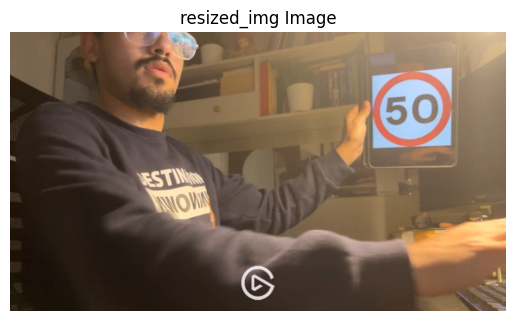

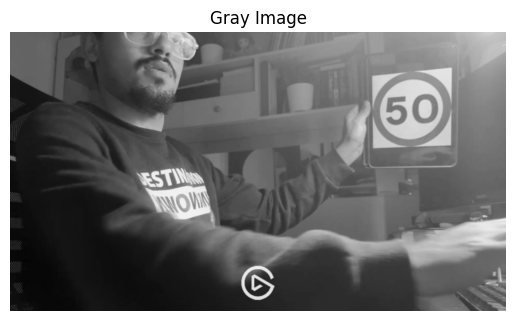

In [9]:

resized_img = cv2.resize(image, (1280, 720))

pp.show_images([resized_img], ["resized_img Image"])

cropped_img = cv2.hconcat([resized_img[:, :(resized_img.shape[1] // 3)]  , resized_img[:, 2 * (resized_img.shape[1] // 3):]])

# Convert the image to grayscale
gray_image = pp.gray_image(resized_img)
pp.show_images([gray_image], ["Gray Image"])

equalized_image = pp.HistogramEqualization(gray_image)

# Apply edge detection
edge_image = pp.LoGEdgeDetection(equalized_image)

# show pp images
#pp.show_images([resized_img, image, cropped_img], ["Input Image", "Cropped Image", "Edge Image"])


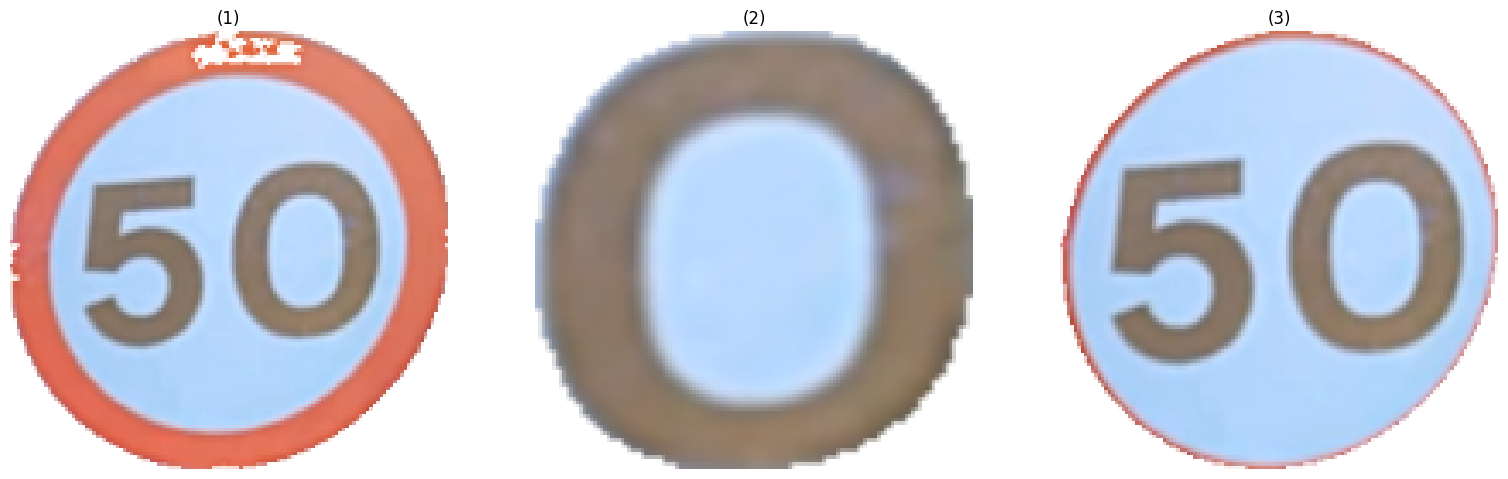

In [10]:

# Extract ROIs
rois = roi.extract_roi(edge_image , resized_img)

# print(rois[0].shape)
#show rois

# new_images = []
# for i in range(len(rois)):
#     #  rois[i] = pp.gray_image(rois[i])
#      new_images.append(pp.HistogramEqualization(rois[i]))

pp.show_images(rois)

C:\Users\yahya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0.339551318371895
0.3181097313322043
0.2555026631778885
0.27971907246234573
0.25040072430030264
0.3070824863561913
0.3079722520103215
0.31989261419618364
[8, 0, 0]
0


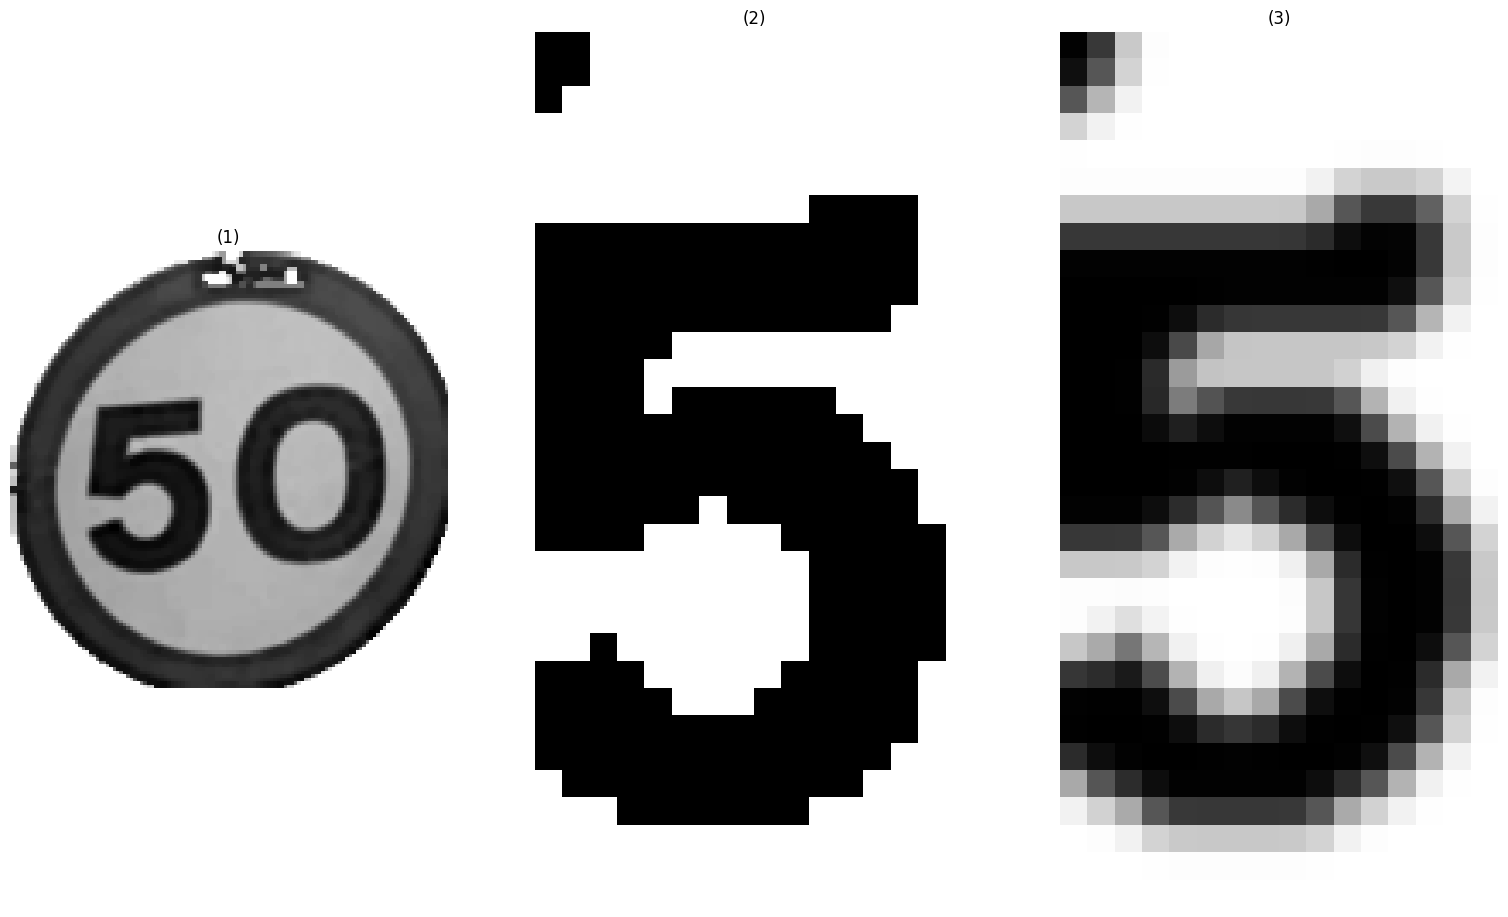

prediction is ['5']


In [19]:
if (len(rois)  == 0):
    print("no rois")
else:
    detected_image_index = detect.detect_sign(rois, sign_imgs_corr)
    print(detected_image_index) 
    if detected_image_index != -1:
        
        # feature_vector , transformed_hog = hog(rois[detected_image_index] , visualize = True , channel_axis=2  , pixels_per_cell=(16, 16) , transform_sqrt=True)
        # pp.show_images([rois[detected_image_index], transformed_hog])

        # red_channel = colored_image[:, :, 0]
        # green_channel = colored_image[:, :, 1]
        # blue_channel = colored_image[:, :, 2]

        # new_image = red_channel.copy()

        # for i in range(new_image.shape[0]):
        #     for j in range(new_image.shape[1]):
        #         if (red_channel[i][j]  < 200 and green_channel[i][j] < 200 and blue_channel[i][j] < 200):
        #             new_image[i][j] = 255
        #         else:
        #             new_image[i][j] = 0

        new_image = pp.gray_image(rois[detected_image_index])


        # #perform opening
        kernel = np.ones((2,2), np.uint8)
        new_image = cv2.erode(new_image, kernel, iterations=2)
        new_image = cv2.dilate(new_image, kernel, iterations=1)
        
        cropped_img = new_image[ 30:100 , 25:61 ]
        resized_img = cv2.resize(cropped_img, (16, 32))

        threshold = filters.threshold_otsu(resized_img)
        thresholded_image = np.zeros(resized_img.shape)
        thresholded_image[resized_img  > threshold] = 1
        blurred_threshold_image = filters.gaussian(thresholded_image , sigma=0.7)

        # show everything
        pp.show_images([new_image , thresholded_image , blurred_threshold_image])
                
                

        print(f'prediction is {numbers_classifier.predict(blurred_threshold_image)}')
    else:
        print("no sign detected")
